Ansys Optimiser


In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import bayes_opt as BayesianOptimization 
import scipy as sp 
import ansys.mapdl.core as asys
import pandas as pd
# \\/ for important nested info
## TO DO
# [] Check value realism
# [] Get optimiser working
# - [] Probably need to check array inputs possible
# - [] 
# [] function variables

In [2]:
asys.close_all_local_instances()

In [3]:
'''
FUNCTIONS
'''

# %% DOUBLE CHECK THESE DON'T HAVE THE OUTLIERS IN
def s_c1(s):
    return 4.905e20*np.exp(-2.256*s) + 2.893e6*np.exp(-0.04024*s)

def s_c2(s):
    return -5.529e8*np.exp(-0.4783*s) + 384.7*np.exp(0.0967*s)

def s_c3(s):
    return 18.3*s**2 - 1744*s + 4.234e4

def breakpoint(datax,dataF,Xph,Fph):    
    # Take integral to this point
    for i in range(len(datax)):
        for j in range(len(Xph)):
            # Find overlap between two arrays where displacement is roughly the same
            if datax[i] >= Xph[j]:
                index = i
                # check force at similar point
                if dataF[index] >= Fph[j]:
                    index_break = index
                    return index_break
                
                
def PH():
    res = 10000
    ## Model Constants
    Lp = 0.02 # [m] Initial Pouch Length - From original kellaris paper (2018)
    perm0 = 8.85418782e-12#[m-3kg-1s4A2]
    permr = 8e3 # for BOPP
    Eb = 700e6 #[V/m] the breakdown strength of BOPP
    w = 0.12 #[m] from original kellaris paper
    t = 15e-6 #[m] Bopp thickness used in initial designs
    #k = 10000 #[Nm-1] Achilles tendon average sourced from Litchwark 2005
    rho_f = 903 #[kgm-3] Bopp Density TEKRA (2020)
    rho_o = 920 #[kgm-3] FR3 Dielectric oil Density Cargill (2018)
    alpf = np.pi/2 #[rad] Assume circular cross section on stroke completion
    Eper = 0.5 # Percentage of electrode coverage
    Va = 100 # Actuation voltage

    ## Swept constants
    #Va = np.linspace(0,10000,1000) # 0 -> 10kV res: 10V
    E = Va/(2*t)
    #Eper = np.linspace(0,1,0.01)

    #Lambda for force
    lamb = E**2*perm0*permr*w*t

    # Electrode length
    Le = Lp*Eper

    #optimal fill eqn based on electrode coverage ratio
    # !!! MIGHT NOT WORK WITH ARRAY !!!
    alpeqn = ((1-Eper)**2)*(2/np.pi) # Easy to calc constant
    y = 0.01 # intial guess of angle
    it = 0.0001 # iteration
    scale = 1.6/it # how many possible
    end = int(scale) # int for loop
    for i in range(0,end): # over scale
        
        func = (y-np.sin(y)*np.cos(y))/(y**2) - alpeqn # Find value of remaining equation with embedded alpha0
        
        if func >= 0: # root is transition from negative to positive in this case
            alp0 = y - it # previous value before sign flip returned       
            break #root found, stop
        else:
            y += it #move to next guess
            continue


    #Height
    h = Lp*(np.sin(alp0)/alp0) # Height [m]

    #Area w/ restraints 
    # !!! MIGHT NOT WORK WITH ARRAY !!!
    A = (Lp - Le)**2 /np.pi # Area [m2]

    #Blocking force
    Fb = (lamb)*(np.cos(alp0)/(1-np.cos(alp0)))

    Lpf = Lp - Le # Fully Deformed pouch length 

    xmax = h - (Lpf*(np.sin(alpf)/alpf)) - Le # max displacement

    alp = np.linspace(alp0,alpf,res) #sweep alpha and SET RESOLUTION

    # Blocks of lp(alp) eqn sweep
    lpnum = 2*A*np.square(alp)
    lpdom = (alp - np.sin(alp)*np.cos(alp))
    lp2 = lpnum/lpdom
    lp = lp2**0.5
    lp[0] = Lp # Removes unphysical discretisation error

    # electrode length sweep
    le = Lp - lp 

    # displacement sweep
    lpmp = np.sin(alp)/alp # lp multiplier in x
    lplpmp = lp*lpmp
    Xph = h - lplpmp - le


    # Force output of actuator
    Fph = lamb*(np.cos(alp)/(1-np.cos(alp)))
    return Fph,Xph



def Sim(coeffs,radius): 
    asys.close_all_local_instances()
    see = asys.launch_mapdl() # launch local instance
    see.clear()
    see.prep7()
    print(see)
    ii = 0
    sim_res = 20
    RF = np.zeros((sim_res,1))
    Energy = np.zeros((sim_res,1))
    change = 1
    for disp_see in np.linspace(0,0.002,sim_res): # Displacements  0 - 20mm 
        value_last = 0
        esize = np.logspace(1.4, 0, 20)
        i = 0
        # while change > 0.1: # Mesh converge
        see.clear()
        see.prep7()
        print(see)
        see.units("SI")


        coeffs = np.array([20,30,20,10])
        radius = np.array([0.020,0.020,0.040,0.030])

        ## ELEMENT
        ## Define Element Type
        # define a PLANE183 element type with thickness
        see.et(1, "PLANE183", kop3=3)
        see.r(1, 0.01)  # thickness of 0.01 meters (10CM)


        ## MATERIAL      
        # TBDE,HYPE,1,,,  
        # TB,HYPE,1,1,2,YEOH  
        # TBTEMP,0
        # TBDATA,,33,44,55,,, 
        for i in range(0,len(coeffs)):
            see.tb("HYPER",i+1,1,2,"YEOH") # Second input is material ID. Need to loop over this for each material
            see.tbtemp(0)
            # calculate from shore hardness 
            C1 = s_c1(coeffs[i])   
            C2 = s_c2(coeffs[i])   
            C3 = s_c3(coeffs[i])     
            see.tbdata(1,C1,C2,C3)
            see.nlgeom("ON")
        ## GEOMETRY
        radius = radius/2 # symmetry and mm -> m conversion

        top = 0.020
        length = 0.100
        z = "0" # 2D


        # Example 

        #      |
        # r5 ----   r1 
        #  \   >c1  /       
        #   \      /
        #    r6---r2
        #  /  >c2  \
        # /         \
        # r7-------- r3
        # \   >c3    /
        #  \        /
        # r8 ---- r4
        #      |
        # # make keypoint at top
        # see.k("1", str(top), str(length), z)# will be point 1

        # KEYPOINT GEN
        # Top down one side 
        j=1
        for i in range(1,len(radius)+1): # for each block
            print(i)
            print(j)
            print(length - (i*length)/len(radius))
            print(radius[i-1])
            see.k(str(j), str(radius[i-1]), str(length - (i*length)/len(radius)), z)
            j += 1 
            # generate a point r/2 from centre line. 

        # top down other side
        for i in range(1,len(radius)+1): # for each block
            print(i)
            print(j)
            print(length - (i*length)/len(radius))
            print(radius[i-1])
            see.k(str(j), str(-radius[i-1]), str(length - (i*length)/len(radius)), z) # invert x here
            j += 1 

        see.kplot(
            show_keypoint_numbering=True,
            background="black",
            show_bounds=True,
            font_size=26,
        )

        # Bullshit to make the keypoint list ACW so area works
        k_forw = np.arange(1,len(radius)+1,1)
        k_back = np.arange(len(radius)+1,2*len(radius)+1,1)
        k_back = np.flip(k_back)
        all_k = np.concatenate((k_forw,k_back))

        # Generate Area
        see.a(*all_k)
        see.aplot(quality=1, show_bounds=True, cpos="iso", show_lines=True)

        ## MESH

        # Make Components for each different silicone region APPEARS TO WORK
        for i in range(1,len(coeffs)+1):
            see.mat(i) #assign material i
            vmin = (i-1)*length/len(coeffs) # min value
            vmax = (i)*length/len(coeffs) # max value
            see.esel("S","CENT","Y",vmin,vmax)
            
        # Define mesh controls
        # Define mesh controls and generate mesh
        elem_size = 0.001 # \\/ variable in function
        see.esize(elem_size) #esize)
        see.amesh("all")
        see.eplot(vtk=True, show_edges=True, show_axes=False, line_width=2, background="k")

        ## Boundary Conditions
        # Fixed bottom with top loaded
        # Create components for defining loads and constraints

        see.nsel("S", "LOC", "Y", 0)     # Select nodes on bottom edge
        see.cm("Y_FIXED", "NODES")       # Create nodal component
        see.d("Y_FIXED", "UY", 0)        # Fix the selected nodes in Y direction
        see.d("Y_FIXED", "UX", 0)        # Fix the selected nodes in X direction

        ## Iterate over a top displacement adn record resultsfor i = 0.25:
        test = 0.01 # 100mm displacement will be changed in func
        see.nsel("S", "LOC", "Y", length) # grab top node
        see.cm("MOVE", "NODES")       # give it a name


        see.slashsolu()  # Enter solution
        see.antype("STATIC", "NEW")  # Specify a new static analysis (Optional)

        see.d("MOVE", "UY", disp_see) # yank it up by func input \\/ variable

        # Solve the model
        see.allsel()
        see.solve()
        see.finish()

        ## Post-processor
        see.post1()
        see.set(1, 1)

        see.post_processing.plot_nodal_displacement(
            "NORM",
            cpos="xy",
            cmap="magma",
        )

        see.post_processing.plot_nodal_eqv_stress(cpos="xy", cmap="magma")

        see.prenergy("SENE")

        # # Mesh Convergence
        # # if the value doesn't cahnge by more than set percentage
        # value = see.fsum("Y_FIXED")
        # if value_last != 0:
        #     change = (value - value_last)/value_last
        #     if change < 0.1: # Currently 10% converge
        #         break
        #     else:
        #         continue
        # value_last = value
        # # Reaction Forces
        # i += 1
        
    RF[ii] = see.fsum("Y_FIXED")
    Energy[ii] = see.prenergy("ALL")
    ## FITNESS
    # take data 
    data_x = np.linspace(0,0.002,20)# model exports
    data_f = RF
    # look for point where SEE F is greater than PH. Cut here
    Fph,Xph = PH()
    break_index = breakpoint(data_x,data_f,Xph,Fph)                
    Energy_final = Energy[break_index]
    print(Energy_final)
    ## FIXA needs mass function 
    return Energy

def Optimise():
    sbounds = {} # empty dict which will take in key values
    for i in range(1,n+1):
        sbounds['s' + str(n)] = (10,60)
    optimizer = BayesianOptimization(
        f = Sim,
        pbounds = sbounds,
        random_state =1,
    )
    optimizer.maximise(
        init_points =3 , 
        n_iter = 10,
    )
    return

In [4]:
test = np.arange(1,10,1)
print(test)
test2 = np.arange(10,10*2,1)
test2 = np.flip(test2)
print(test2)

np.concatenate((test,test2))

[1 2 3 4 5 6 7 8 9]
[19 18 17 16 15 14 13 12 11 10]


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 19, 18, 17, 16, 15, 14, 13, 12,
       11, 10])

In [5]:

see = asys.launch_mapdl() # launch local instance
see.clear()
see.prep7()
print(see)

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...
Product:             Ansys Mechanical Enterprise Academic Student
MAPDL Version:       23.1
ansys.mapdl Version: 0.64.1



Product:             Ansys Mechanical Enterprise Academic Student
MAPDL Version:       23.1
ansys.mapdl Version: 0.64.1

1
1
0.07500000000000001
0.01
2
2
0.05
0.01
3
3
0.024999999999999994
0.02
4
4
0.0
0.015
1
5
0.07500000000000001
0.01
2
6
0.05
0.01
3
7
0.024999999999999994
0.02
4
8
0.0
0.015


c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


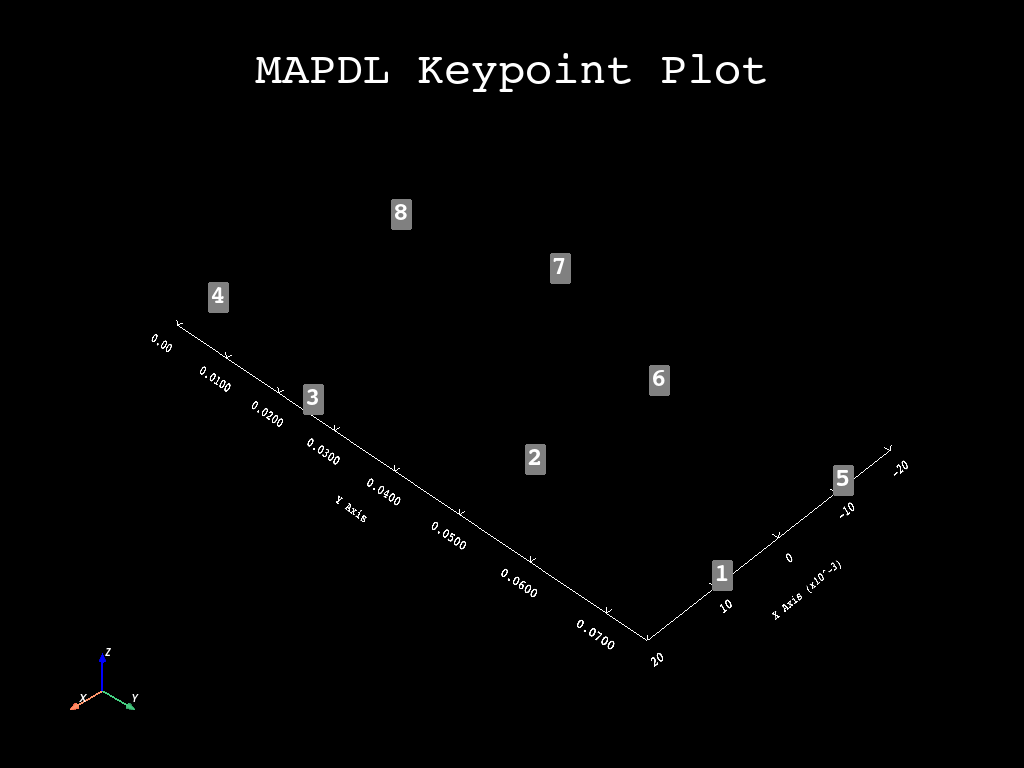

c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


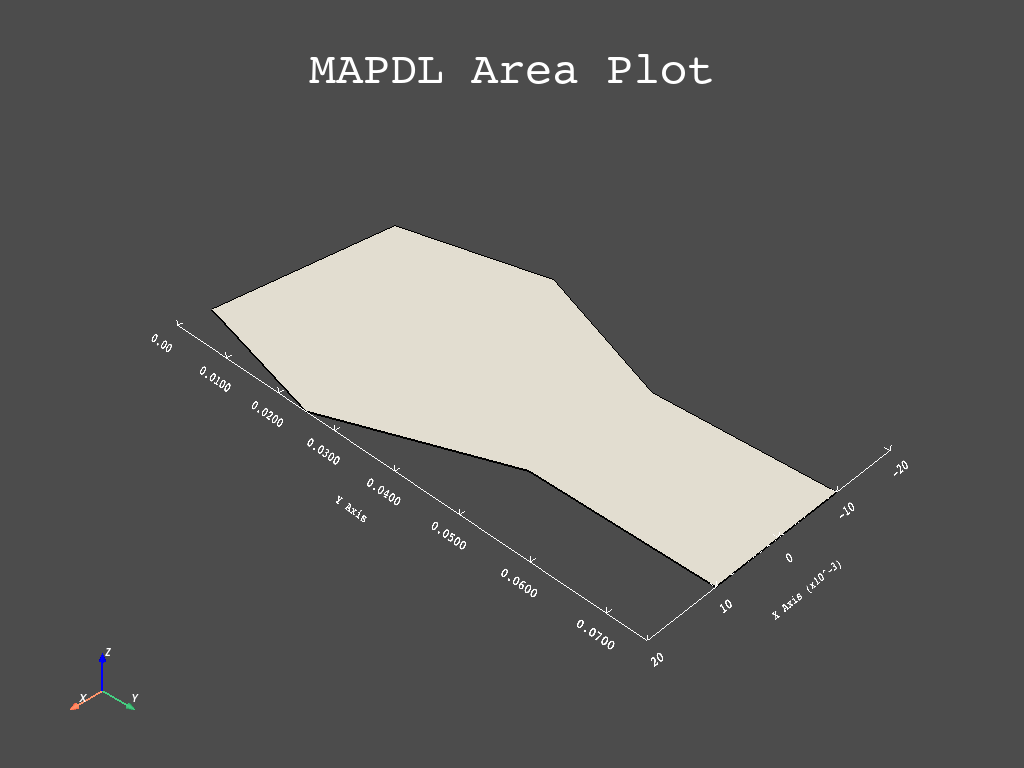

c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\jupyter\notebook.py:58: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


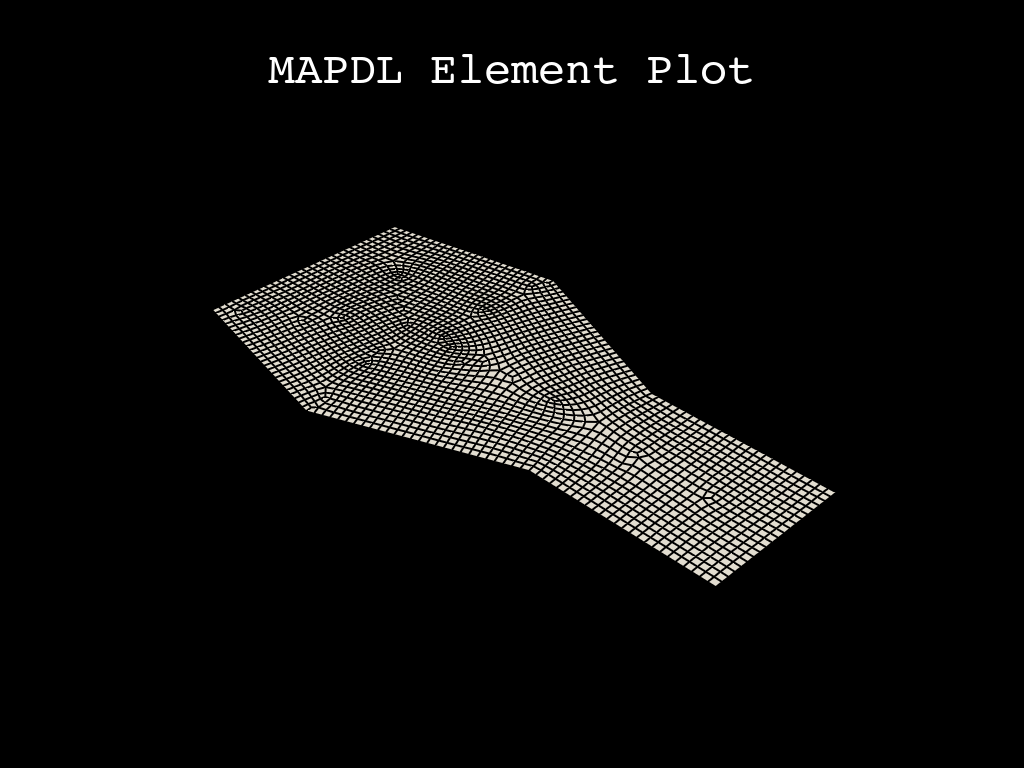

Exception in thread Threaded `close_mapdl` function:
Traceback (most recent call last):
  File "c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Threaded `close_mapdl` function:
Traceback (most recent call last):
  File "c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
Exception in thread Threaded `close_mapdl` function:
Traceback (most recent call last):
  File "c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self.run()
  File "c:\Users\Harri\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c

MapdlRuntimeError: 

Error in instance GRPC_127.0.0.1:50052

USE LOAD STEP     1  SUBSTEP     1  FOR LOAD CASE 0 
 *** ERROR ***                           CP =       8.016   TIME= 11:42:11
 Load set not found on result file file.rst.

In [6]:
'''
Test Code
'''
ii = 0
sim_res = 2
RF = np.zeros((sim_res,1))
Energy = np.zeros((sim_res,1))
for disp_see in np.linspace(0,0.2,sim_res): # Displacements  0 - 20mm 
    # value_last = 0
    # for esize in np.logspace(1.4, 0, 20): # Mesh converge
    see.clear()
    see.prep7()
    print(see)
    see.units("SI")


    coeffs = np.array([20,30,20,10])
    radius = np.array([0.020,0.020,0.040,0.030])

    ## ELEMENT
    ## Define Element Type
    # define a PLANE183 element type with thickness
    see.et(1, "PLANE182", kop3=3)
    see.r(1, 0.01)  # thickness of 0.01 meters (10CM)


    ## MATERIAL 
    # - I think this needs to happen for every shore hardness and then I assign these to elements 
    # - I am not sure how to do this yet.
    # TBDE,HYPE,1,,,  
    # TB,HYPE,1,1,2,YEOH  
    # TBTEMP,0
    # TBDATA,,33,44,55,,, 
    for i in range(0,len(coeffs)):
        see.tb("HYPER",i+1,1,2,"YEOH") # Second input is material ID. Need to loop over this for each material
        see.tbtemp(0)
        # calculate from shore hardness 
        C1 = s_c1(coeffs[i])   
        C2 = s_c2(coeffs[i])   
        C3 = s_c3(coeffs[i])     
        see.tbdata(1,C1,C2,C3)
        see.nlgeom("ON")
    ## GEOMETRY
    radius = radius/2 # symmetry and mm -> m conversion

    top = 0.020
    length = 0.100
    z = "0" # 2D


    # Example 

    #      |
    # r5 ----   r1 
    #  \   >c1  /       
    #   \      /
    #    r6---r2
    #  /  >c2  \
    # /         \
    # r7-------- r3
    # \   >c3    /
    #  \        /
    # r8 ---- r4
    #      |
    # # make keypoint at top
    # see.k("1", str(top), str(length), z)# will be point 1

    # KEYPOINT GEN
    # Top down one side 
    j=1
    for i in range(1,len(radius)+1): # for each block
        print(i)
        print(j)
        print(length - (i*length)/len(radius))
        print(radius[i-1])
        see.k(str(j), str(radius[i-1]), str(length - (i*length)/len(radius)), z)
        j += 1 
        # generate a point r/2 from centre line. 

    # top down other side
    for i in range(1,len(radius)+1): # for each block
        print(i)
        print(j)
        print(length - (i*length)/len(radius))
        print(radius[i-1])
        see.k(str(j), str(-radius[i-1]), str(length - (i*length)/len(radius)), z) # invert x here
        j += 1 

    see.kplot(
        show_keypoint_numbering=True,
        background="black",
        show_bounds=True,
        font_size=26,
    )

    # Bullshit to make the keypoint list ACW so area works
    k_forw = np.arange(1,len(radius)+1,1)
    k_back = np.arange(len(radius)+1,2*len(radius)+1,1)
    k_back = np.flip(k_back)
    all_k = np.concatenate((k_forw,k_back))

    # Generate Area
    see.a(*all_k)
    see.aplot(quality=1, show_bounds=True, cpos="iso", show_lines=True)

    ## MESH

    # Make Components for each different silicone region APPEARS TO WORK
    for i in range(1,len(coeffs)+1):
        see.mat(i) #assign material i
        vmin = (i-1)*length/len(coeffs) # min value
        vmax = (i)*length/len(coeffs) # max value
        see.esel("S","CENT","Y",vmin,vmax)
        
    # Define mesh controls
    # Define mesh controls and generate mesh
    elem_size = 0.001 # \\/ variable in function
    see.esize(elem_size)
    see.amesh("all")
    see.eplot(vtk=True, show_edges=True, show_axes=False, line_width=2, background="k")

    ## Boundary Conditions
    # Fixed bottom with top loaded
    # Create components for defining loads and constraints

    see.nsel("S", "LOC", "Y", 0)     # Select nodes on bottom edge
    see.cm("Y_FIXED", "NODES")       # Create nodal component
    see.d("Y_FIXED", "UY", 0)        # Fix the selected nodes in Y direction
    see.d("Y_FIXED", "UX", 0)        # Fix the selected nodes in X direction

    ## Iterate over a top displacement adn record resultsfor i = 0.25:
    test = 0.01 # 100mm displacement will be changed in func
    see.nsel("S", "LOC", "Y", length) # grab top node
    see.cm("MOVE", "NODES")       # give it a name


    see.slashsolu()  # Enter solution
    see.antype("STATIC", "NEW")  # Specify a new static analysis (Optional)
    see.nsubst(200,0,0)
    see.d("MOVE", "UY", disp_see) # yank it up by func input \\/ variable

    # Solve the model
    see.allsel()
    see.solve()
    see.finish()

    ## Post-processor
    see.post1()
    # see.set(1, 1)

    see.post_processing.plot_nodal_displacement(
        "NORM",
        cpos="xy",
        cmap="magma",
    )

    see.post_processing.plot_nodal_eqv_stress(cpos="xy", cmap="magma")

    see.prenergy("SENE")

    # Mesh Convergence
    # if the value doesn't cahnge by more than set percentage
    # value = see.fsum("Y_FIXED")
    # if value_last != 0:
    #     change = (value - value_last)/value_last
    #     if change < 0.1: # Currently 10% converge
    #         break
    #     else:
    #         continue
    # value_last = value
    # # Reaction Forces
    
RF[ii] = see.fsum("Y_FIXED")
Energy[ii] = see.prenergy("ALL")
## FITNESS
# take data 
data_x = np.linspace(0,0.002,20)# model exports
data_f = RF
# look for point where SEE F is greater than PH. Cut here
Fph,Xph = PH()
break_index = breakpoint(data_x,data_f,Xph,Fph)                
Energy_final = Energy[break_index]
print(Energy_final)
# return Energy

In [ ]:
# %%
# Init
global n 

n = 5

# opt
Optimise()